
# Experiments for extracting images of Boyd's Bird Journal into computer readable form

(See image below)

The journals are PDFs containing a series of scanned images of observations of birds. The observations are scanned handwritten notes on graph paper. There are bird species labels running down the left side of the page and date information across the top. The charts are organized by month with days of the month being column headings. There are between 2 and three months of information for each image.

Each cell has a mark indicating the presence or absence of a bird species on a given day. So there is, potentially, one mark per bird species per day. The mark on the page is typically a forward slash "/" but it can also be an "x" or an asterisk "*". We are treating all types of marks the same, a cell either has a mark or it doesn't.

Somethings to note here:
- The graphs are not clean and contain notes and stray marks.
- The scans do not always have nice strong lines to pick out.
- The scans of the graphs are crooked and contain distortions, so the lines are slightly bent, typically near the edges.
- Some of the lines are incomplete or missing. In the image below, May 1986 has more grid cells than June 1986. And the line to the left of May 1st is incomplete.

<img  src="assets/Boyd_M_Bird_journal_section1-024.png"/>

In [1]:
%load_ext watermark
%watermark -a 'Raphael LaFrance' -i -u -v -r -g -p numpy,matplotlib,skimage

Raphael LaFrance 
last updated: 2017-10-25T06:25:34-04:00

CPython 3.6.1
IPython 6.2.1

numpy 1.13.3
matplotlib 2.1.0
skimage 0.13.1
Git hash: 2439c05decef57d890e449949005478a9909600f
Git repo: https://github.com/rafelafrance/boyd-bird-journal.git


## Extract images from PDF files

First we need to extract individual images from the PDFs. This is easily accomplished in Linux with the command `pdfimages`. This is part of either the poppler or xpdf packages. We're using `bash` to make a directory to hold the images and then extracting the PDF images into that directory. The first 20 images are not relevant here.

In [2]:
%%bash

RAW_DATA='raw_data'
DIRECTORY='images'

PDF1="$RAW_DATA/Boyd_M_Bird_journal_section1.pdf"
PDF2="$RAW_DATA/Boyd_M_Bird_journal_section2.pdf"

PREFIX1="$DIRECTORY/Boyd_M_Bird_journal_section1"
PREFIX2="$DIRECTORY/Boyd_M_Bird_journal_section2"

if [ ! -d "$DIRECTORY" ]; then
    mkdir $DIRECTORY
    pdfimages -png $PDF1 $PREFIX1
    pdfimages -png $PDF2 $PREFIX2
fi

## Setup

We are using a fairly standard scipy stack: `numpy` & `matplotlib`. The only addition is the use of `scikit-image`.

In [3]:
# %matplotlib notebook
%matplotlib inline

import os
import csv
from itertools import product
from collections import namedtuple

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import patches, cm

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# import cv2

from skimage import io
from skimage import util
# from skimage.filters import sobel
from skimage.transform import hough_line, hough_line_peaks
from skimage.transform import probabilistic_hough_line, rotate

## Brief description of the Hough transform

We're using the Hough Transform to find lines in the image. It's an efficient and old algorithm for finding objects in an image. Efficient because it only scans the image once.

The basic idea of the algorithm is:

1. Set up a table of every possible line in the image. The lines are in polar form (rho, theta).
    1. Lines are limited to a given set of angles.
    1. This table will hold a count of all of the "on" pixels for the line.
1. Scan the image for "on" pixels.
1. When a pixel is "on", add one to every possible line that goes thru the pixel it.
1. After every pixel has been recorded choose all lines with a count that is greater than a given threshold.

See the [Wikipedia Page](https://en.wikipedia.org/wiki/Hough_transform) for a more detailed description.

## Define some convenience objects

In [4]:
Crop = namedtuple('Crop', 'north south west east')
Offset = namedtuple('Offset', 'x y')
Point = namedtuple('Point', 'x y')

#### This is the main grid class. It holds the other classes.

In [5]:
class Grid:

    def __init__(self, *, file_name=None, grid=None, crop=None):
        if file_name:
            self.image = io.imread(file_name)
            self.offset = Offset(0, 0)
        elif grid:
            self.image = grid.image
            self.offset = grid.offset
            if crop:
                self.image = util.crop(
                    self.image,
                    ((crop.north, crop.south), (crop.west, crop.east)))
                self.offset = Offset(x=self.offset.x + crop.west,
                                     y=self.offset.y + crop.north)

        self.edges = util.invert(self.image)

        self.horiz = Horizontal(self.edges)
        self.vert = Vertical(self.edges)

        self.cells = []
        self.row_labels = []
        self.col_labels = []

    @property
    def shape(self):
        return self.edges.shape

    @property
    def width(self):
        return self.horiz.size

    @property
    def height(self):
        return self.vert.size

    def get_row_labels(self):
        self.row_labels = [row[1].is_row_label() for row in self.cells]
        for i in range(1, len(self.cells) - 2):
            if self.row_labels[i - 1] and self.row_labels[i + 1]:
                self.row_labels[i] = True

    def get_col_labels(self):
        self.col_labels = [cell.is_col_label() for cell in self.cells[0]]
        self.col_labels[0] = False

    def get_cells(self):
        self.cells = []
        for row, (n, s) in enumerate(zip(self.horiz.lines[:-1], self.horiz.lines[1:])):
            self.cells.append([])
            for col, (w, e) in enumerate(zip(self.vert.lines[:-1], self.vert.lines[1:])):
                self.cells[row].append(Cell(self, n, s, w, e))

#### This is the base object for working with grid lines. We use if for both vertical and horizontal grid lines.

In [6]:
class GridLines:
    def __init__(self, image):
        self.image = image
        self.thetas = None
        self.angles = []
        self.dists = []
        self.lines = []
        self.threshold = 500
        self.min_distance = 40

    def find_lines(self):
        h_matrix, h_angles, h_dist = hough_line(self.image, self.thetas)

        _, self.angles, self.dists = hough_line_peaks(
            h_matrix,
            h_angles,
            h_dist,
            threshold=self.threshold,
            min_distance=self.min_distance)

    def polar2endpoints(self, angle, dist):
        if np.abs(angle) > np.pi / 4:
            x0 = 0
            x1 = self.image.shape[1]
            y0 = int(np.round(dist / np.sin(angle)))
            y1 = int(np.round((dist - x1 * np.cos(angle)) / np.sin(angle)))
        else:
            y0 = 0
            y1 = self.image.shape[0]
            x0 = int(np.round(dist / np.cos(angle)))
            x1 = int(np.round((dist - y1 * np.sin(angle)) / np.cos(angle)))

        return [x0, y0], [x1, y1] 

    def add_line(self, point1, point2):
        self.lines.append((point1, point2))
        self.sort_lines()

    def sort_lines(self):
        self.lines = sorted(self.lines, key=self.sort_key)

    def find_grid_lines(self):
        self.find_lines()

        self.lines = [self.polar2endpoints(t, r)
                      for (t, r) in zip(self.angles, self.dists)]

        self.sort_lines()

#### Given a set of near horizontal angles we can find horizontal grid lines

In [7]:
class Horizontal(GridLines):
    def __init__(self, image):
        super().__init__(image)
        self.size = image.shape[1]

    def find_grid_lines(self, add_top_edge=False, add_bottom_edge=False):
        super().find_grid_lines()

        if add_top_edge:
            self.add_line([0, 0], [self.image.shape[1], 0])

        if add_bottom_edge:
            self.add_line([0, self.image.shape[0]],
                          [self.image.shape[1], self.image.shape[0]])

    @staticmethod
    def sort_key(x):
        return x[0][1]

#### Given a set of near vertical angles we can find vertical grid lines

In [8]:
class Vertical(GridLines):
    def __init__(self, image):
        super().__init__(image)
        self.size = image.shape[0]

    def find_grid_lines(self, add_left_edge=False, add_right_edge=False):
        super().find_grid_lines()

        if add_left_edge:
            self.add_line([0, 0], [0, self.image.shape[0]])

        if add_right_edge:
            self.add_line([self.image.shape[1], 0],
                          [self.image.shape[1], self.image.shape[0]])

    @staticmethod
    def sort_key(x):
        return x[0][0]

#### Given horizontal and vertical grid lines we can define a grid cell

In [9]:
class Cell:
    row_label_threshold = 20
    col_label_threshold = 20
    crop = ((4, 4), (4, 4))
    # near_vert_deg = np.linspace(0.0, 10.0, num=81)
    # near_vert = np.deg2rad(near_vert_deg)

    def __init__(self, grid, north=None, south=None, west=None, east=None):
        self.image = grid.edges
        self.nw = self.intersection(north, west)
        self.sw = self.intersection(south, west)
        self.ne = self.intersection(north, east)
        self.se = self.intersection(south, east)
        self.offset = Offset(x=grid.offset.x + self.nw.x,
                             y=grid.offset.y + self.nw.y)

    def intersection(self, line1, line2):
        (x1, y1), (x2, y2) = line1
        (x3, y3), (x4, y4) = line2
        denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
        num1 = x1 * y2 - y1 * x2
        num2 = x3 * y4 - y3 * x4
        px = num1 * (x3 - x4) - (x1 - x2) * num2
        px /= denom
        py = num1 * (y3 - y4) - (y1 - y2) * num2
        py /= denom
        return Point(int(px), int(py))

    def interior(self, crop=None):

        north = max(self.nw.y, self.ne.y)
        south = self.image.shape[0] - min(self.sw.y, self.se.y)
        west = max(self.nw.x, self.sw.x)
        east = self.image.shape[1] - min(self.ne.x, self.se.x)

        inside = util.crop(self.image, ((north, south), (west, east)))

        if crop:
            inside = util.crop(inside, crop)

        return inside

    def is_row_label(self):
        return np.mean(self.interior(self.crop)) > self.row_label_threshold

    def is_col_label(self):
        inside = self.interior(crop=self.crop)
        lines = self.has_line()
        return len(lines) or np.mean(inside) > self.col_label_threshold

    def has_line(self, angles=None):
        return probabilistic_hough_line(
            self.interior(crop=self.crop), line_length=15, line_gap=2, theta=angles)

    def get_patch(self):
        width = self.ne.x - self.nw.x
        height = self.sw.y - self.nw.y
        x = self.offset.x
        y = self.offset.y
        return (x, y), width, height

In [10]:
in_file = 'images/Boyd_M_Bird_journal_section1-026.png'
full_image = Grid(file_name=in_file)

## Split the image into left-hand and right-hand sides

In [11]:
split = int(full_image.width / 2)

left_side = Grid(grid=full_image, crop=Crop(north=0, south=0, west=0, east=split))
right_side = Grid(grid=full_image, crop=Crop(north=0, south=0, west=split, east=0))

print(full_image.shape)
print(left_side.shape)
print(right_side.shape)

(5100, 3300)
(5100, 1650)
(5100, 1650)


## Get the horizontal and vertical grid lines

As described above, we need to define a line as a threshold on the line count. However, there is a wrinkle, the images are not square with the width being the shorter dimension (3300px width x 5100px height). To accommodate this we will make two passes over the image. One for the horizontal lines and one for the vertical line.

In [12]:
near_horiz_deg = np.linspace(-2.0, 2.0, num=41)
near_vert_deg = np.linspace(88.0, 92.0, num=41)

# I'm not sure why this is required?!
near_horiz_deg, near_vert_deg = near_vert_deg, near_horiz_deg

left_side.horiz.thetas = np.deg2rad(near_horiz_deg)
left_side.vert.thetas = np.deg2rad(near_vert_deg)

print(np.rad2deg(left_side.horiz.thetas))
print(np.rad2deg(left_side.vert.thetas))

[ 88.   88.1  88.2  88.3  88.4  88.5  88.6  88.7  88.8  88.9  89.   89.1
  89.2  89.3  89.4  89.5  89.6  89.7  89.8  89.9  90.   90.1  90.2  90.3
  90.4  90.5  90.6  90.7  90.8  90.9  91.   91.1  91.2  91.3  91.4  91.5
  91.6  91.7  91.8  91.9  92. ]
[-2.  -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1 -1.  -0.9 -0.8 -0.7 -0.6
 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9  2. ]


#### Find the horizontal grid lines for the left half of the image

In [13]:
left_side.horiz.threshold = left_side.width * 0.4

left_side.horiz.find_grid_lines(add_top_edge=True, add_bottom_edge=True)

print(len(left_side.horiz.angles))
print(np.rad2deg(left_side.horiz.angles))

100
[ 91.2  91.3  91.3  91.2  91.2  91.2  91.2  91.2  90.6  91.2  91.1  91.2
  91.3  91.2  91.2  91.   91.2  91.2  91.2  91.2  91.2  91.3  91.2  91.3
  91.2  91.2  91.3  91.3  91.3  91.2  91.2  91.2  91.2  91.2  91.3  91.2
  91.2  91.1  91.2  91.2  91.3  91.2  91.2  91.1  91.2  91.1  91.1  91.3
  91.2  91.2  91.1  91.1  91.1  91.1  91.2  91.2  91.2  91.1  91.2  91.2
  91.1  91.1  91.2  91.2  91.2  91.2  91.2  91.1  91.2  91.1  91.2  91.1
  91.2  91.2  91.1  91.1  91.2  91.2  91.2  91.2  91.2  91.2  91.2  91.2
  91.2  91.1  91.2  91.1  91.2  91.2  91.2  91.2  91.1  91.2  91.1  90.9
  91.2  91.1  91.1  91.1]


#### Find the vertical grid lines for the left half of the image

In [14]:
left_side.vert.threshold = left_side.height * 0.4

left_side.vert.find_grid_lines(add_left_edge=True, add_right_edge=True)

print(len(left_side.vert.angles))
print(np.rad2deg(left_side.vert.angles))

1
[ 0.7]


#### Add a vertical grid line after the first one.

We're expecting two columns of cells on the left side of the image. The cells are rather long and typically have lots of whitespace toward the right end. We expect the 1st cell to have a row number and the 2nd cell to have the bird's species identification. We are going to look at the 2nd cell to see if there is any writing in it. To help boost the signal we are going to chop the 2nd cell at a fixed width and look at that part for writing.

In [15]:
west = left_side.vert.lines[1][0][0] + 200
point1 = [west, 0]
point2 = [west, left_side.height]
left_side.vert.add_line(point1, point2)
for line in left_side.vert.lines:
    print(line)

([0, 0], [0, 5100])
([541, 0], [478, 5100])
([741, 0], [741, 5100])
([1650, 0], [1650, 5100])


#### Look at the grid from the left side of the image

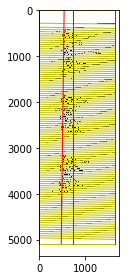

In [16]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.imshow(left_side.image, cmap=plt.cm.gray)

for ((x0, y0), (x1, y1)) in left_side.horiz.lines:
    ax.plot((x0, x1), (y0, y1), '-y', linewidth=1)

for ((x0, y0), (x1, y1)) in left_side.vert.lines:
    ax.plot((x0, x1), (y0, y1), '-r', linewidth=1)

plt.tight_layout()
plt.show()

## Get grid cells in the left side of the image

We want the interior area of each cell.

In [17]:
left_side.get_cells()
print(len(left_side.cells))
print(len(left_side.cells[0]))

101
3


## Look for writing in the second cell of each row

In [18]:
left_side.get_row_labels()

no label


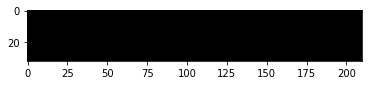

In [19]:
# @interact(row=(0, len(left_side.cells) - 1), col=(0, len(left_side.cells[0]) - 1))
def draw_row_label_interior(row, col):
    print('has label' if left_side.row_labels[row] else 'no label')
    fig, ax = plt.subplots(figsize=(6, 2))
    ax.imshow(left_side.cells[row][col].interior(crop=Cell.crop), cmap=plt.cm.gray)

draw_row_label_interior(24, 1)

### Now split the right side into separate graphs

In [20]:
months = []
for r, row in enumerate(left_side.row_labels[1:], 1):

    if not left_side.row_labels[r - 1] and row:
        north = left_side.cells[r - 1][1].ne.y

    if left_side.row_labels[r - 1] and not row:
        south = left_side.cells[r][1].se.y
        months.append(Grid(
            grid=right_side,
            crop=Crop(north=north, south=right_side.height - south, west=0, east=0)))

for month in months:
    print(month.shape)

(1031, 1650)
(932, 1650)
(941, 1650)


In [21]:
for m, month in enumerate(months):
    month.horiz.threshold = month.width * 0.4
    month.horiz.thetas = np.deg2rad(near_horiz_deg)

    month.horiz.find_grid_lines(add_bottom_edge=True)

    month.vert.threshold = month.height * 0.4
    month.vert.thetas = np.deg2rad(near_vert_deg)

    month.vert.find_grid_lines(add_left_edge=True, add_right_edge=True)

    month.get_cells()
    month.get_col_labels()

    print('month: {} rows: {}  cols: {}'.format(
        m, len(month.cells), len(month.cells[0])))

month: 0 rows: 22  cols: 31
month: 1 rows: 20  cols: 32
month: 2 rows: 20  cols: 32


#### Look the resulting grid

In [22]:
@interact(mon=(0, len(months) - 1))
def show_month_grid(mon):
    month = months[mon]
    fig, ax = plt.subplots(figsize=(6, 6))

    ax.imshow(month.image, cmap=plt.cm.gray)
    ax.set_title('Grid {}'.format(mon))

    for ((x0, y0), (x1, y1)) in month.horiz.lines:
        ax.plot((x0, x1), (y0, y1), '-y', linewidth=1)

    for ((x0, y0), (x1, y1)) in month.vert.lines:
        ax.plot((x0, x1), (y0, y1), '-r', linewidth=1)

    plt.tight_layout()
    plt.show()

# show_month_grid(0)

interactive(children=(IntSlider(value=1, description='mon', max=2), Output()), _dom_classes=('widget-interact',))

### Find column labels

In [23]:
@interact(mon=(0, len(months) - 1), col=(0, 35))
def draw_column_header_interior(mon, col):
    month = months[mon]
    col = -1 if col >= len(month.cells[0]) else col

    cell = month.cells[0][col]
    interior = cell.interior(crop=Cell.crop)

    mean = np.mean(interior)
    print('mean', mean)
    print('yes' if cell.is_col_label() else '')

    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(interior, cmap=plt.cm.gray)

    lines = cell.has_line()
    for ((x0, y0), (x1, y1)) in lines:
        ax.plot((x0, x1), (y0, y1), '-r', linewidth=1)

# draw_column_header_interior(0, 1)

interactive(children=(IntSlider(value=1, description='mon', max=2), IntSlider(value=17, description='col', max=35), Output()), _dom_classes=('widget-interact',))

### Look for forward slashes in grid cells

In [24]:
forward_slashes = np.linspace(65.0, 25.0, num=161)
print(forward_slashes)
forward_slashes = np.deg2rad(forward_slashes)

[ 65.    64.75  64.5   64.25  64.    63.75  63.5   63.25  63.    62.75
  62.5   62.25  62.    61.75  61.5   61.25  61.    60.75  60.5   60.25  60.
  59.75  59.5   59.25  59.    58.75  58.5   58.25  58.    57.75  57.5
  57.25  57.    56.75  56.5   56.25  56.    55.75  55.5   55.25  55.    54.75
  54.5   54.25  54.    53.75  53.5   53.25  53.    52.75  52.5   52.25  52.
  51.75  51.5   51.25  51.    50.75  50.5   50.25  50.    49.75  49.5
  49.25  49.    48.75  48.5   48.25  48.    47.75  47.5   47.25  47.    46.75
  46.5   46.25  46.    45.75  45.5   45.25  45.    44.75  44.5   44.25  44.
  43.75  43.5   43.25  43.    42.75  42.5   42.25  42.    41.75  41.5
  41.25  41.    40.75  40.5   40.25  40.    39.75  39.5   39.25  39.    38.75
  38.5   38.25  38.    37.75  37.5   37.25  37.    36.75  36.5   36.25  36.
  35.75  35.5   35.25  35.    34.75  34.5   34.25  34.    33.75  33.5
  33.25  33.    32.75  32.5   32.25  32.    31.75  31.5   31.25  31.    30.75
  30.5   30.25  30.    29.75  29.

In [25]:
@interact(mon=(0, len(months) - 1), row=(1, 40), col=(0, 35))
def draw_cell_interior(mon, row, col):
    month = months[mon]
    row = -1 if row >= len(month.cells) else row
    col = -1 if col >= len(month.cells[0]) else col

    cell = month.cells[row][col]
    interior = cell.interior(Cell.crop)

    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(interior, cmap=plt.cm.gray)

    lines = probabilistic_hough_line(
        interior, line_length=15, theta=forward_slashes)
    for ((x0, y0), (x1, y1)) in lines:
        ax.plot((x0, x1), (y0, y1), '-r', linewidth=1)

    print('lines', len(lines))
    print('yes' if len(lines) else '')


# draw_cell_interior(1, 18, 30)
# draw_cell_interior(1, 27, 27)

interactive(children=(IntSlider(value=1, description='mon', max=2), IntSlider(value=20, description='row', max=40, min=1), IntSlider(value=17, description='col', max=35), Output()), _dom_classes=('widget-interact',))

In [27]:
@interact(mon=(0, len(months) - 1))
def show_slashes(mon):
    month = months[mon]
    for row in month.cells[1:-1]:
        for col, cell in enumerate(row):
            if month.col_labels[col]:
                print('/' if cell.has_line(forward_slashes) else '.', end=' ')
        print()
# show_slashes(0)

interactive(children=(IntSlider(value=1, description='mon', max=2), Output()), _dom_classes=('widget-interact',))

### Stitch image parts back together to report output

This image shows how we broke up the input image to get the monthly charts. Doing it this way reduces distortion.

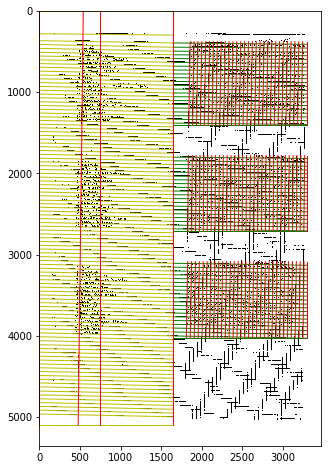

In [28]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(full_image.image, cmap=plt.cm.gray)

for ((x0, y0), (x1, y1)) in left_side.horiz.lines:
    ax.plot((x0, x1), (y0, y1), '-y', linewidth=1)

for ((x0, y0), (x1, y1)) in left_side.vert.lines:
    ax.plot((x0, x1), (y0, y1), '-r', linewidth=1)

for month in months:
    for ((x0, y0), (x1, y1)) in month.horiz.lines:
        x0 += month.offset.x
        x1 += month.offset.x
        y0 += month.offset.y
        y1 += month.offset.y
        ax.plot((x0, x1), (y0, y1), '-g', linewidth=1)

    for ((x0, y0), (x1, y1)) in month.vert.lines:
        x0 += month.offset.x
        x1 += month.offset.x
        y0 += month.offset.y
        y1 += month.offset.y
        ax.plot((x0, x1), (y0, y1), '-r', linewidth=1)

plt.show()

## Output the results

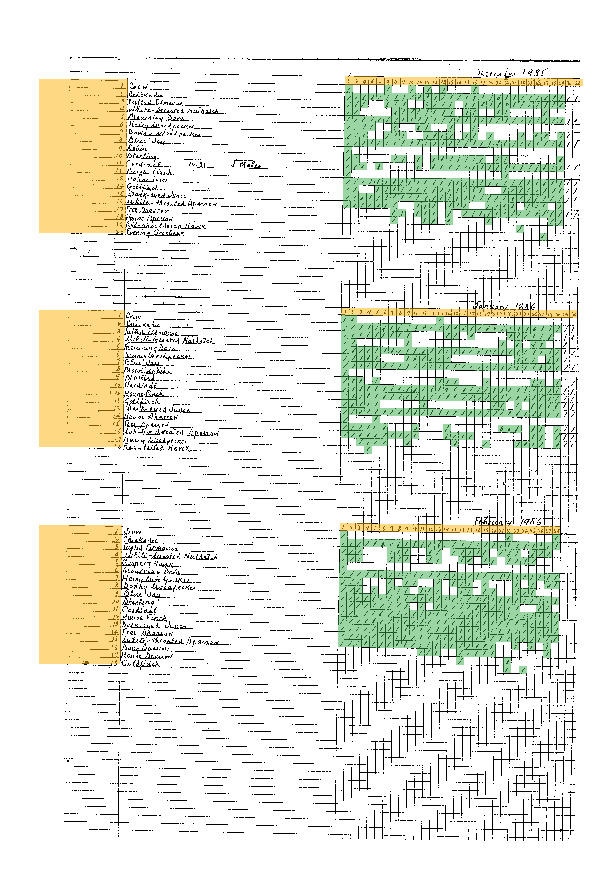

In [31]:
file_name = os.path.basename(in_file)

base_name, _ = os.path.splitext(file_name)
csv_path = os.path.join('output', base_name + '.csv')
img_path = os.path.join('output', base_name + '_out.png')


with open(csv_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    header = ['file_name', 'chart_in_file',
              'year', 'month', 'row_no', 'bird_species']
    header += [i for i in range(1, 32)]
    writer.writerow(header)

    fig, ax = plt.subplots(figsize=(10, 15.45), frameon=False)
    ax.imshow(full_image.image, cmap=plt.cm.gray)
    ax.axis('off')

    # Color in row labels
    for r, row in enumerate(left_side.cells):
        if left_side.row_labels[r]:
            nw, width, height = row[0].get_patch()
            ax.add_patch(patches.Rectangle(
                nw, width, height, alpha=0.5, facecolor='#feb209'))

    for m, month in enumerate(months):

        # Color in column labels
        for col, cell in enumerate(month.cells[0]):
            if month.col_labels[col]:
                nw, width, height = cell.get_patch()
                ax.add_patch(patches.Rectangle(
                    nw, width, height, alpha=0.5, facecolor='#feb209'))

        # Color in grid cells with slashes
        for r, cell_row in enumerate(month.cells[1:-1]):
            row = [base_name, m + 1, '', '', r + 1, '']
            csv_cells = ['' for i in range(31)]
            h = -1
            for col, cell in enumerate(cell_row):
                if month.col_labels[col]:
                    h += 1
                    if cell.has_line(forward_slashes):
                        nw, width, height = cell.get_patch()
                        ax.add_patch(patches.Rectangle(
                            nw, width, height, alpha=0.5, facecolor='#39ad48'))
                        csv_cells[h] = 1
            row += csv_cells
            writer.writerow(row)

plt.savefig(img_path, dpi=300, bbox_inches='tight')

# Failed experiments

- Try merging endpoints: Lines are pretty skew across the entire image. I tried to use interior points to make grid lines. This didn't really help things.

- Probabilistic Hough line: This may work for other parts of the image, like slashes, but it didn't help with either grid lines or row labels. It proved to be much slower and harder to tune for finding grid lines that span the entire image.

- OpenCV: This works, it's just less flexible for searching on a limited set of angles. The ability to pull out the horizontal, vertical, and diagonal lines separately is useful in this application. Also, OpenCV is difficult to install.